In [1]:
!pip install opendatasets

**Download dataset**

In [2]:
import opendatasets as od
import pandas as pd

In [3]:
# key for api: 9b3fb9923f7bb7dc471d66be1e4ab296
# username:  manhhung2310
# instruction for downloading kaggle dataset using colab: https://www.geeksforgeeks.org/how-to-import-kaggle-datasets-directly-into-google-colab/
od.download_kaggle_dataset(dataset_url='https://www.kaggle.com/datasets/mohansacharya/graduate-admissions?select=Admission_Predict.csv',data_dir='./dataset')

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: manhhung2310
Your Kaggle Key: ··········


100%|██████████| 9.64k/9.64k [00:00<00:00, 20.2MB/s]

**import libraries**

In [4]:
import torch
import numpy as np
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

### Data analysis

In [5]:
data = pd.read_csv("./dataset/graduate-admissions/Admission_Predict.csv")
data.head()

,Serial No.,GRE Score,TOEFL Score,University Rating,SOP,LOR,CGPA,Research,Chance of Admit
0,1,337,118,4,4.5,4.5,9.65,1,0.92
1,2,324,107,4,4.0,4.5,8.87,1,0.76
2,3,316,104,3,3.0,3.5,8.00,1,0.72
3,4,322,110,3,3.5,2.5,8.67,1,0.80
4,5,314,103,2,2.0,3.0,8.21,0,0.65


In [6]:
# The serial No. adds nothing to predicting the chance of admittance
data = data.drop('Serial No.',axis=1)

In [7]:
# show the distributions of data
data.describe()

,GRE Score,TOEFL Score,University Rating,SOP,LOR,CGPA,Research,Chance of Admit
count,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000
mean,316.807500,107.410000,3.087500,3.400000,3.452500,8.598925,0.547500,0.724350
std,11.473646,6.069514,1.143728,1.006869,0.898478,0.596317,0.498362,0.142609
min,290.000000,92.000000,1.000000,1.000000,1.000000,6.800000,0.000000,0.340000
25%,308.000000,103.000000,2.000000,2.500000,3.000000,8.170000,0.000000,0.640000
50%,317.000000,107.000000,3.000000,3.500000,3.500000,8.610000,1.000000,0.730000
75%,325.000000,112.000000,4.000000,4.000000,4.000000,9.062500,1.000000,0.830000
max,340.000000,120.000000,5.000000,5.000000,5.000000,9.920000,1.000000,0.970000


Correlation in a nutshell: 


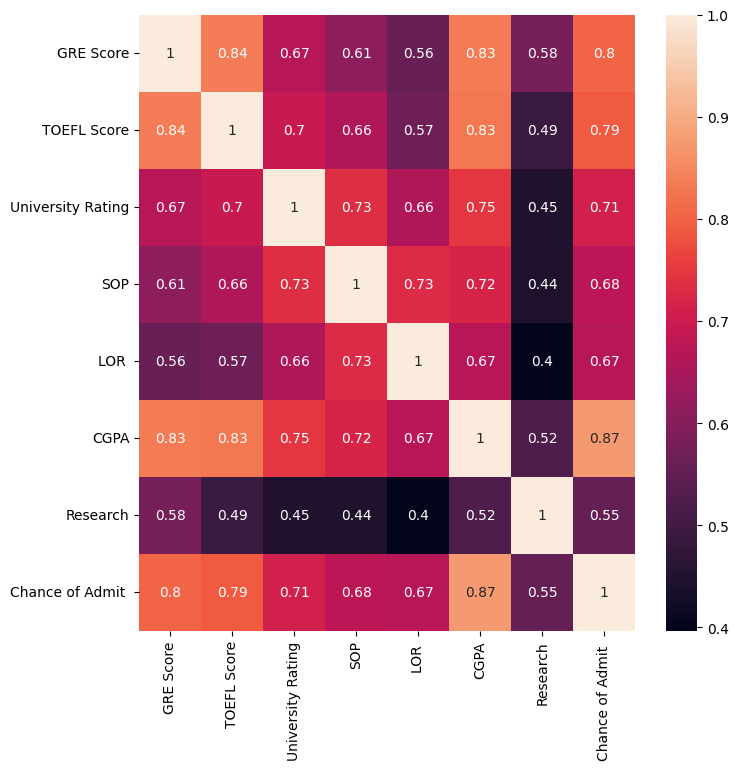

In [8]:
fig = plt.figure(figsize=(8, 8))
sns.heatmap(data.corr(), annot=True)
fig.show()
print("Correlation in a nutshell: ")

### Main flow for data + model processing

In [9]:
target = data.pop('Chance of Admit ')

In [10]:
data

,GRE Score,TOEFL Score,University Rating,SOP,LOR,CGPA,Research
0,337,118,4,4.5,4.5,9.65,1
1,324,107,4,4.0,4.5,8.87,1
2,316,104,3,3.0,3.5,8.00,1
3,322,110,3,3.5,2.5,8.67,1
4,314,103,2,2.0,3.0,8.21,0
...,...,...,...,...,...,...,...
395,324,110,3,3.5,3.5,9.04,1
396,325,107,3,3.0,3.5,9.11,1
397,330,116,4,5.0,4.5,9.45,1
398,312,103,3,3.5,4.0,8.78,0


In [11]:
target

0      0.92
1      0.76
2      0.72
3      0.80
4      0.65
       ... 
395    0.82
396    0.84
397    0.91
398    0.67
399    0.95
Name: Chance of Admit , Length: 400, dtype: float64

In [12]:
# split data into train test
X_train,X_test,y_train,y_test = train_test_split(data.values.astype(np.float32),
                                                 target.values.reshape(-1,1).astype(np.float32),
                                                 test_size=.2,
                                                random_state=42)

In [13]:
# standard scaler processing
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

*model*

In [14]:
class MyModule(nn.Module):
    def __init__(self):
        super(MyModule,self).__init__()

        self.module = nn.Sequential(
            nn.Linear(7,10),
            nn.Linear(10,1)
        )

    def forward(self,X):
        X = self.module(X)
        return X

In [15]:
# Hyperparamters
learningRate = 0.0001
epochs = 15000

In [16]:
model = MyModule()

In [17]:
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learningRate)
# Reshape the labels
y_train = y_train.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)

In [18]:
verbose=True
all_loss = []
for epoch in range(epochs+1):

    # Convert the data into torch tensors
    inputs = Variable(torch.from_numpy(X_train)).float()
    label = Variable(torch.from_numpy(y_train)).float()

    # Clear the existing Gradients from the optimizer
    optimizer.zero_grad()

    # Pass the data thorugh model and get one set of predictions
    output = model(inputs)

    # Calculate the loss from the obtained predictions and the ground truth values
    loss = torch.sqrt(criterion(output, label))
    all_loss.append(loss.item())

    # Calculate gradients by doing one step of back propagation
    loss.backward()

    # Apply those gradients to the weights by doing one step of optimizer
    optimizer.step()

    # For monitoring and debugging
    if verbose and epoch % 1000 == 0:
        print(f"Epoch: {epoch}  |  Loss: {all_loss[-1]}")

Epoch: 0  |  Loss: 4.453457832336426
Epoch: 1000  |  Loss: 0.08983185142278671
Epoch: 2000  |  Loss: 0.06816603243350983
Epoch: 3000  |  Loss: 0.0666736289858818
Epoch: 4000  |  Loss: 0.06655289977788925
Epoch: 5000  |  Loss: 0.06584794819355011
Epoch: 6000  |  Loss: 0.06548707187175751
Epoch: 7000  |  Loss: 0.06538266688585281
Epoch: 8000  |  Loss: 0.0649164691567421
Epoch: 9000  |  Loss: 0.06465931981801987
Epoch: 10000  |  Loss: 0.06468889117240906
Epoch: 11000  |  Loss: 0.06437449157238007
Epoch: 12000  |  Loss: 0.06404335051774979
Epoch: 13000  |  Loss: 0.06387882679700851
Epoch: 14000  |  Loss: 0.06372425705194473
Epoch: 15000  |  Loss: 0.06358707696199417


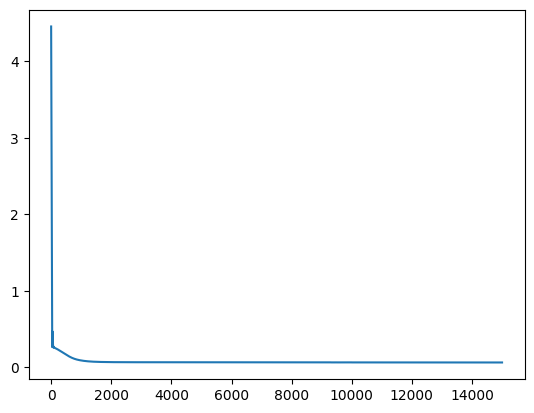

In [19]:
plt.plot(all_loss)

In [20]:
# Test the model and compute Validation Accuracy
VAL_inp = Variable(torch.from_numpy(X_test)).float()

y_pred = model(VAL_inp).detach().numpy()

# Calculate R^2 Accuracy (used for regression where discrete values are absent)
rss = sum((y_test - y_pred)**2)       # Residual Sum of Squares
tss = sum((y_test - y_test.mean())**2) # Total Sum of Squares

r2_accuracy = (1 - rss / tss)
print(f"Validation Accuracy of the model is: {r2_accuracy.squeeze() * 100} %")

Validation Accuracy of the model is: 80.59673309326172 %


Text(0, 0.5, 'actual')

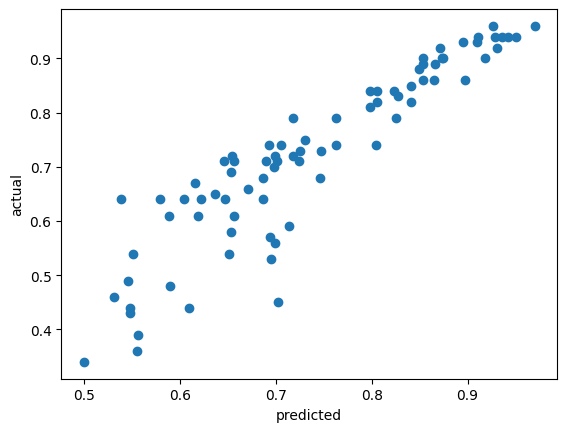

In [21]:
plt.scatter(y_pred,y_test)
plt.xlabel('predicted')
plt.ylabel('actual')